In [1]:
# Imports
from google.cloud import language
from google.cloud.language import enums, types
import os
import pandas as pd
import numpy as np
import time
from scipy import stats
import matplotlib.pyplot as plt
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Loading the data set (note we use the unbalanced classes file).
gameDf = pd.read_csv('gameDfClean.csv')

In [3]:
# The csv has the list of chat messages as a single string. This function recovers the python list.
gameDf['chats'] = gameDf['chats'].apply(ast.literal_eval)

In [4]:
# Different preprocessing steps are used for sentiment analysis to preserve sentence structure and context.
def preprocessingGCP(flat):
    gameInitialisms = {"gg":"good game","mb":"my bad","gj":"good job","lol":"laugh out loud","wtf":"what the fuck"}
    result1 = []
    for chat in flat:
        newchat = []
        for i in range(len(chat.split())):
            if chat.split()[i] in gameInitialisms.keys():
                newchat.append(gameInitialisms[chat.split()[i]])
            else:
                newchat.append(chat.split()[i])
        result1.append(" ".join(newchat))
    result2 = ". ".join(result1)
    return result2

In [5]:
# Applying the preprocessing function.
gameDf['chatsGCP'] = gameDf['chats'].map(preprocessingGCP)

In [6]:
# Wrapping the calls to Google Cloud Sentiment API in a function
def analyze(chatLog):
    client = language.LanguageServiceClient()
    type_ = enums.Document.Type.PLAIN_TEXT
    document = {"content": chatLog, "type": type_, "language": "en"}
    encoding_type = enums.EncodingType.UTF8
    response = client.analyze_sentiment(document, encoding_type=encoding_type)
    result = [response.document_sentiment.score,response.document_sentiment.magnitude]
    return result

In [7]:
# Cell to query GCP API for sentiment values

# chatLogs = gameDf['chatsGCP'].tolist()
# sentiments = []
# for chatLog in chatLogs:
#     result = analyze(chatLog)
#     sentiments.append(result)
#     time.sleep(0.1)

In [8]:
# Collecting results into a dataframe to merge with the matches.
sentimentsDf = pd.DataFrame(sentiments)
sentimentsDf.columns = ['score','magnitude']
gameDf = gameDf.join(sentimentsDf)

In [9]:
# Small cleanup of the dataframe.
gameDf.set_index("gameid",inplace=True)
gameDf.drop(gameDf.columns[0],axis=1,inplace=True)

In [10]:
# Calculating mean sentiment score for wins and losses.
gameDf.groupby("result").mean()['score']

result
0    0.298396
1    0.442909
Name: score, dtype: float64

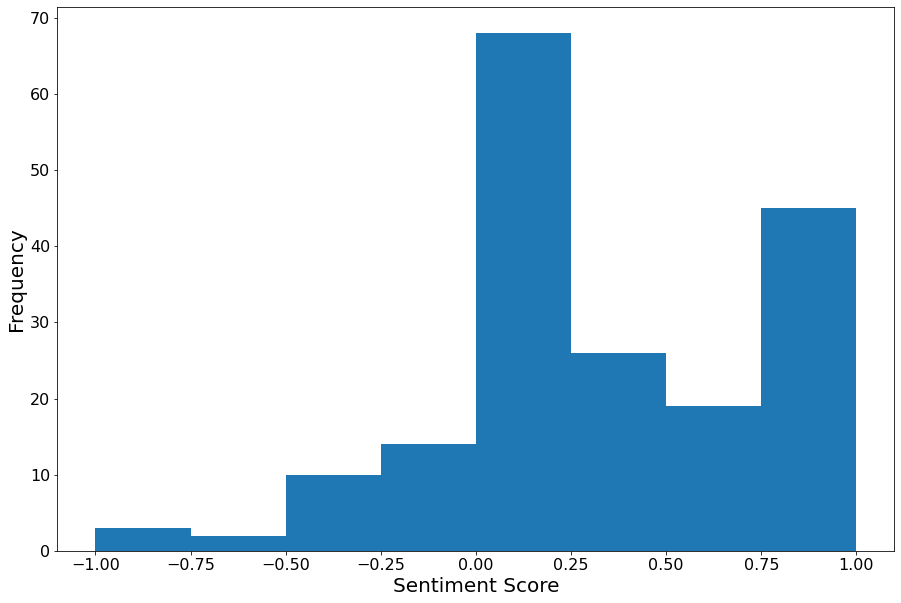

In [11]:
# Plotting histogram of sentiment scores for losses.
plt.figure(figsize=(15,10))
plt.hist(gameDf[gameDf['result']==0]['score'].tolist(),bins=8,range=(-1,1))
plt.xticks(fontsize=16)
plt.xlabel("Sentiment Score",fontsize=20)
plt.ylabel("Frequency",fontsize=20)
plt.yticks(fontsize=16)
plt.show()

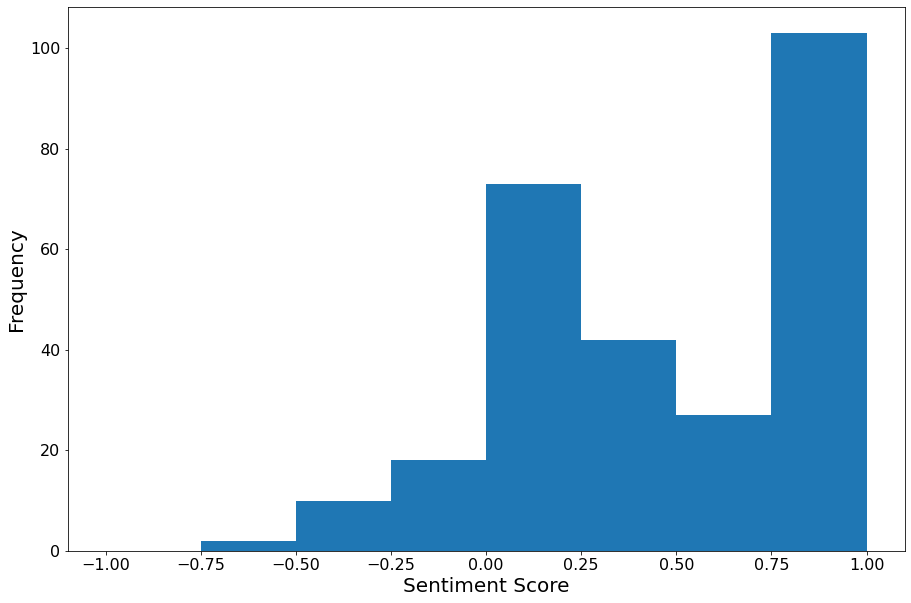

In [12]:
# Plotting histogram of sentiment scores for wins.
plt.figure(figsize=(15,10))
plt.hist(gameDf[gameDf['result']==1]['score'].tolist(),bins=8,range=(-1,1))
plt.xticks(fontsize=16)
plt.xlabel("Sentiment Score",fontsize=20)
plt.ylabel("Frequency",fontsize=20)
plt.yticks(fontsize=16)
plt.show()

In [13]:
# Performing t-test of win and loss sentiment scores.
stats.ttest_ind(gameDf[gameDf['result']==0]['score'].tolist(), gameDf[gameDf['result']==1]['score'].tolist(),equal_var=False)

Ttest_indResult(statistic=-3.5815796750050497, pvalue=0.0003847795048721211)